# 08. PyTorch Paper Replicating Exercises

## 0. Resources

These exercises/solutions are based on section 08. PyTorch Paper Replicating of the Learn PyTorch for Deep Learning course by Zero to Mastery: https://www.learnpytorch.io/08_pytorch_paper_replicating/

## 1. Get various imports and helper functions

In [1]:
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

import matplotlib.pylab as plt

from src import get_data, setup_data, engine

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else (
    "mps" if torch.mps.is_available() else "cpu"
)
device

'mps'

## 2. Get data

In [3]:
# Download data
get_data.get_data(
    data_dir_str="data/",
    image_path_str="pizza_steak_sushi_20_percent",
    data_url_str="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    file_name_str="pizza_steak_sushi_20_percent.zip"
)

get_data.get_data(
    data_dir_str="data/",
    image_path_str="pizza_steak_sushi_10_percent",
    data_url_str="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    file_name_str="pizza_steak_sushi.zip"
)

data/pizza_steak_sushi_20_percent exists...
Data in data/pizza_steak_sushi_20_percent already exits, skipping downloading and unzipping...
Finished getting data...
data/pizza_steak_sushi_10_percent exists...
Data in data/pizza_steak_sushi_10_percent already exits, skipping downloading and unzipping...
Finished getting data...


In [4]:
# Setup directories
from pathlib import Path

train_dir_10 = Path("data/pizza_steak_sushi_10_percent/train")
test_dir_10 = Path("data/pizza_steak_sushi_10_percent/test")

train_dir_20 = Path("data/pizza_steak_sushi_20_percent/train")
test_dir_20 = Path("data/pizza_steak_sushi_20_percent/test")

In [5]:
train_dir_10, test_dir_10

(PosixPath('data/pizza_steak_sushi_10_percent/train'),
 PosixPath('data/pizza_steak_sushi_10_percent/test'))

In [6]:
train_dir_20, test_dir_20

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 3. Preprocess data

In [7]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = setup_data.create_dataloaders(
    train_dir=train_dir_20,
    test_dir=test_dir_20,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([3, 224, 224]), tensor(1))

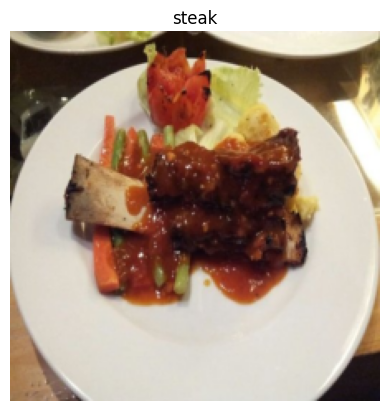

In [10]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)
plt.show()

## 4. Replicate the ViT architecture we created with in-built PyTorch transformer layers.

* You'll want to look into replacing our `TransformerEncoderBlock()` class with `torch.nn.TransformerEncoderLayer()` (these contain the same layers as our custom blocks)
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with `torch.nn.TransformerEncoder()`

In [11]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768) -> None:
        super().__init__()
        
        self.patch_size = patch_size
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0,)
        
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3,)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        image_resolution = x.shape[-1]
        assert image_resolution %  self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        x_permuted = x_flattened.permute(0, 2, 1)
        
        return x_permuted

In [12]:
class ViT(nn.Module):
    def __init__(self,
                 image_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0.0,
                 mlp_dropout:float=0.0,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000,):
        super().__init__()
        
        self.num_patches = (image_size * image_size) // patch_size ** 2
        
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim))
        
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        self.transformer_encoder = nn.Sequential(*[nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                              nhead=num_heads,
                                                                              dim_feedforward=mlp_size,
                                                                              dropout=mlp_dropout,
                                                                              activation="gelu",
                                                                              batch_first=True,
                                                                              norm_first=True,) for _ in range(num_transformer_layers)])
    
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                        nn.Linear(in_features=embedding_dim,
                                                  out_features=num_classes))
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        
        x = self.patch_embedding(x)
        
        x = torch.cat((class_token, x), dim=1)
        
        x = self.position_embedding + x
        
        x = self.embedding_dropout(x)
    
        x = self.transformer_encoder(x)
        
        x = self.classifier(x[:, 0])
        
        return x

In [13]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.0, inplace=False)
      (dropout2): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768

In [14]:
summary(model=vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, witdh)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [1, 3, 224, 224]     [1, 1000]            152,064              True
├─PatchEmbedding (patch_embedding)                 [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                            [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                           [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                      [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                 [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderLayer (0)                 [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─LayerNorm (norm1)                  

## 5. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like `from vit import ViT`
* We covered the art of turning code cells into Python scrips in 05. PyTorch Going Modular

In [15]:
%%writefile src/vit.py
import torch
from torch import nn


class _PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768) -> None:
        super().__init__()

        self.patch_size = patch_size

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0,)

        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3,)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        x_permuted = x_flattened.permute(0, 2, 1)

        return x_permuted


class ViT(nn.Module):
    def __init__(self,
                 image_size: int = 224,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 num_transformer_layers: int = 12,
                 embedding_dim: int = 768,
                 mlp_size: int = 3072,
                 num_heads: int = 12,
                 attn_dropout: float = 0.0,
                 mlp_dropout: float = 0.0,
                 embedding_dropout: float = 0.1,
                 num_classes: int = 1000,):
        super().__init__()

        self.num_patches = (image_size * image_size) // patch_size ** 2

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        self.position_embedding = nn.Parameter(
            data=torch.randn(1, self.num_patches + 1, embedding_dim))

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.patch_embedding = _PatchEmbedding(in_channels=in_channels,
                                               patch_size=patch_size,
                                               embedding_dim=embedding_dim)

        self.transformer_encoder = nn.Sequential(*[nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                              nhead=num_heads,
                                                                              dim_feedforward=mlp_size,
                                                                              dropout=mlp_dropout,
                                                                              activation="gelu",
                                                                              batch_first=True,
                                                                              norm_first=True,) for _ in range(num_transformer_layers)])

        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                        nn.Linear(in_features=embedding_dim,
                                                  out_features=num_classes))

    def forward(self, x):
        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0])

        return x

Overwriting src/vit.py


In [16]:
from src.vit import ViT

vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): _PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.0, inplace=False)
      (dropout2): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=76

In [17]:
summary(model=vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, witdh)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [1, 3, 224, 224]     [1, 1000]            152,064              True
├─_PatchEmbedding (patch_embedding)                [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                            [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                           [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                      [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                 [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderLayer (0)                 [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─LayerNorm (norm1)                  

## 6. Train a pretrained ViT feature extractor model (like the one we made in 08. PyTorch Paper Replicating section 10) on 20% of the pizza, steak and sushi data like the dataset we used in 07. PyTorch Experiment Tracking section 7.3

* See how it performs compared to the EffNetB2 model we compared it to in 08. PyTorch Paper Replicating section 10.6.

In [18]:
train_dataloader_20, test_dataloader_20, class_names = setup_data.create_dataloaders(train_dir=train_dir_20,
                                                                                     test_dir=test_dir_20,
                                                                                     transform=manual_transforms,
                                                                                     batch_size=32,
                                                                                     num_workers=1,)

len(train_dataloader_20), len(test_dataloader_20), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [19]:
vit = ViT(num_transformer_layers=4,
          num_classes=len(class_names))

In [20]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_20,
                           test_dataloader=test_dataloader_20,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=10,
                           device="cpu")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.3409 | train_acc: 0.2896 | test_loss: 1.2220 | test_acc: 0.3625
Epoch: 2 | train_loss: 1.1584 | train_acc: 0.3458 | test_loss: 1.1072 | test_acc: 0.3625
Epoch: 3 | train_loss: 1.1349 | train_acc: 0.3208 | test_loss: 1.1436 | test_acc: 0.2875
Epoch: 4 | train_loss: 1.1073 | train_acc: 0.3271 | test_loss: 1.1608 | test_acc: 0.2875
Epoch: 5 | train_loss: 1.1170 | train_acc: 0.3750 | test_loss: 1.1089 | test_acc: 0.3500
Epoch: 6 | train_loss: 1.1692 | train_acc: 0.3542 | test_loss: 1.0926 | test_acc: 0.3500
Epoch: 7 | train_loss: 1.1291 | train_acc: 0.3229 | test_loss: 1.1081 | test_acc: 0.2875
Epoch: 8 | train_loss: 1.1246 | train_acc: 0.3792 | test_loss: 1.3775 | test_acc: 0.2875
Epoch: 9 | train_loss: 1.2142 | train_acc: 0.3333 | test_loss: 1.1018 | test_acc: 0.2875
Epoch: 10 | train_loss: 1.0892 | train_acc: 0.3854 | test_loss: 1.1580 | test_acc: 0.2875


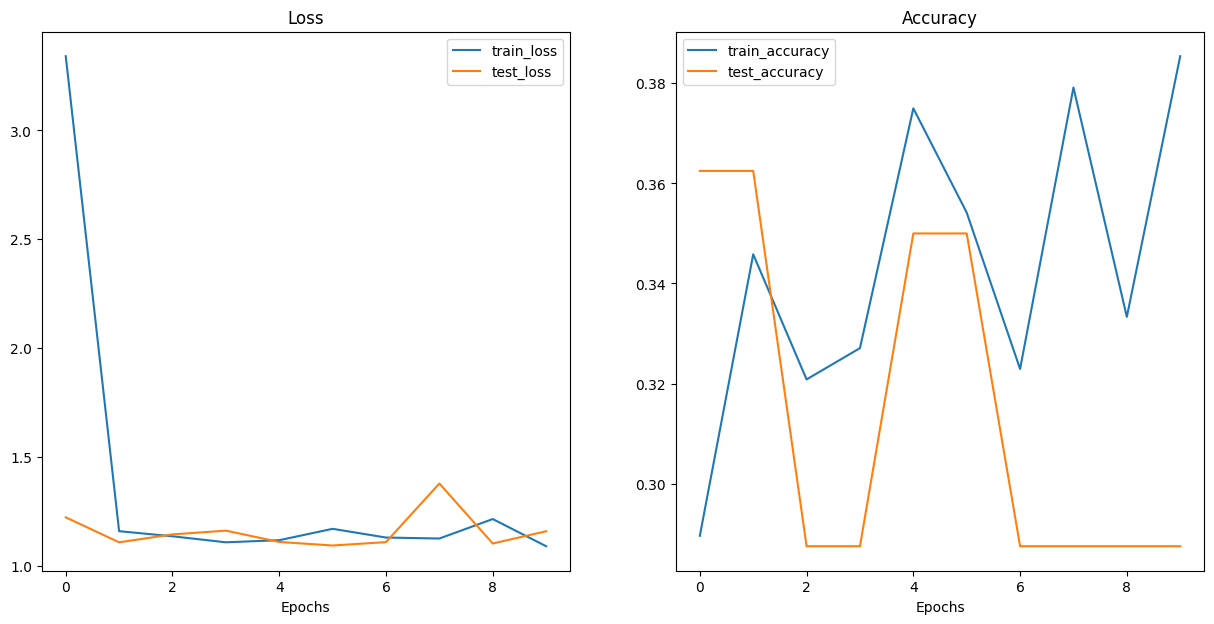

In [21]:
from src.helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [22]:
effnet_transform = torchvision.models.EfficientNet_B0_Weights.DEFAULT.transforms()
effnet_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [23]:
train_dataloader_20_effnet, test_dataloader_20_effnet, _ = setup_data.create_dataloaders(train_dir=train_dir_20,
                                                                                         test_dir=test_dir_20,
                                                                                         transform=effnet_transform,
                                                                                         batch_size=32,
                                                                                         num_workers=1)
len(train_dataloader_20_effnet), len(test_dataloader_20_effnet), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [24]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
effnet = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [25]:
for param in effnet.features.parameters():
    param.requires_grad=False

In [26]:
effnet.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

In [27]:
optimizer = torch.optim.Adam(params=effnet.parameters(),
                             lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

effnet_results = engine.train(model=effnet,
                              train_dataloader=train_dataloader_20_effnet,
                              test_dataloader=test_dataloader_20_effnet,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=10,
                              device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0014 | train_acc: 0.5417 | test_loss: 0.6798 | test_acc: 0.8722
Epoch: 2 | train_loss: 0.7092 | train_acc: 0.8187 | test_loss: 0.5787 | test_acc: 0.8727
Epoch: 3 | train_loss: 0.5595 | train_acc: 0.8458 | test_loss: 0.4742 | test_acc: 0.9006
Epoch: 4 | train_loss: 0.4637 | train_acc: 0.8979 | test_loss: 0.4171 | test_acc: 0.9068
Epoch: 5 | train_loss: 0.4603 | train_acc: 0.8625 | test_loss: 0.3947 | test_acc: 0.9193
Epoch: 6 | train_loss: 0.3735 | train_acc: 0.9021 | test_loss: 0.3555 | test_acc: 0.9068
Epoch: 7 | train_loss: 0.3691 | train_acc: 0.9125 | test_loss: 0.3447 | test_acc: 0.9102
Epoch: 8 | train_loss: 0.3533 | train_acc: 0.9208 | test_loss: 0.3161 | test_acc: 0.9227
Epoch: 9 | train_loss: 0.3448 | train_acc: 0.9104 | test_loss: 0.3021 | test_acc: 0.9222
Epoch: 10 | train_loss: 0.3487 | train_acc: 0.8750 | test_loss: 0.2946 | test_acc: 0.9290


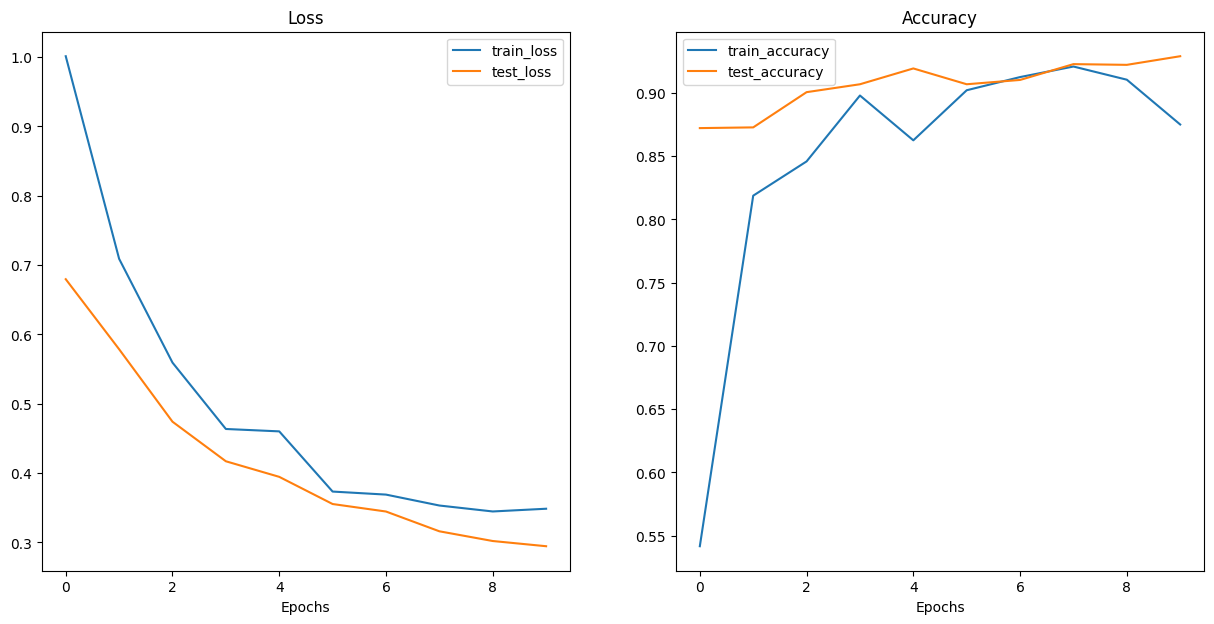

In [28]:
plot_loss_curves(effnet_results)

## 7. Try repeating the steps from excercise 3 but this time use the `ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1` pretrained weights from `torchvision.models.vit_b_16()`.

* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights .transforms() method.

In [29]:
vit_b_16_transforms = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1.transforms()
vit_b_16_transforms

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [30]:
train_dataloader_20_vit_b_16, test_dataloader_20_vit_b_16, _ = setup_data.create_dataloaders(train_dir=train_dir_20,
                                                                                         test_dir=test_dir_20,
                                                                                         transform=vit_b_16_transforms,
                                                                                         batch_size=32,
                                                                                         num_workers=1)
len(train_dataloader_20_vit_b_16), len(test_dataloader_20_vit_b_16), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [31]:
weights_vit_b_16 = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
vit_b_16 = torchvision.models.vit_b_16(weights=weights_vit_b_16).to(device)

In [32]:
for param in vit_b_16.parameters():
    param.requires_grad=False

In [33]:
vit_b_16.heads = nn.Sequential(
    nn.Linear(in_features=768,
              out_features=len(class_names), 
              bias=True)
).to(device)

In [34]:
optimizer = torch.optim.Adam(params=vit_b_16.parameters(),
                             lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

vit_b_16_results = engine.train(model=vit_b_16,
                              train_dataloader=train_dataloader_20_vit_b_16,
                              test_dataloader=test_dataloader_20_vit_b_16,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=10,
                              device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2769 | train_acc: 0.9146 | test_loss: 0.0360 | test_acc: 1.0000


Python(29697) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 2 | train_loss: 0.0690 | train_acc: 0.9875 | test_loss: 0.0108 | test_acc: 1.0000


Python(30175) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31125) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 3 | train_loss: 0.0342 | train_acc: 0.9896 | test_loss: 0.0107 | test_acc: 1.0000


Python(31484) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(33190) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 4 | train_loss: 0.0257 | train_acc: 0.9938 | test_loss: 0.0065 | test_acc: 1.0000


Python(33603) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34245) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 5 | train_loss: 0.0161 | train_acc: 0.9958 | test_loss: 0.0065 | test_acc: 1.0000


Python(34581) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(35252) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 6 | train_loss: 0.0120 | train_acc: 1.0000 | test_loss: 0.0053 | test_acc: 1.0000


Python(35554) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(36195) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 7 | train_loss: 0.0093 | train_acc: 1.0000 | test_loss: 0.0044 | test_acc: 1.0000


Python(36624) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37534) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 8 | train_loss: 0.0071 | train_acc: 1.0000 | test_loss: 0.0038 | test_acc: 1.0000


Python(37685) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37970) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 9 | train_loss: 0.0062 | train_acc: 1.0000 | test_loss: 0.0035 | test_acc: 1.0000


Python(38092) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 10 | train_loss: 0.0052 | train_acc: 1.0000 | test_loss: 0.0032 | test_acc: 1.0000


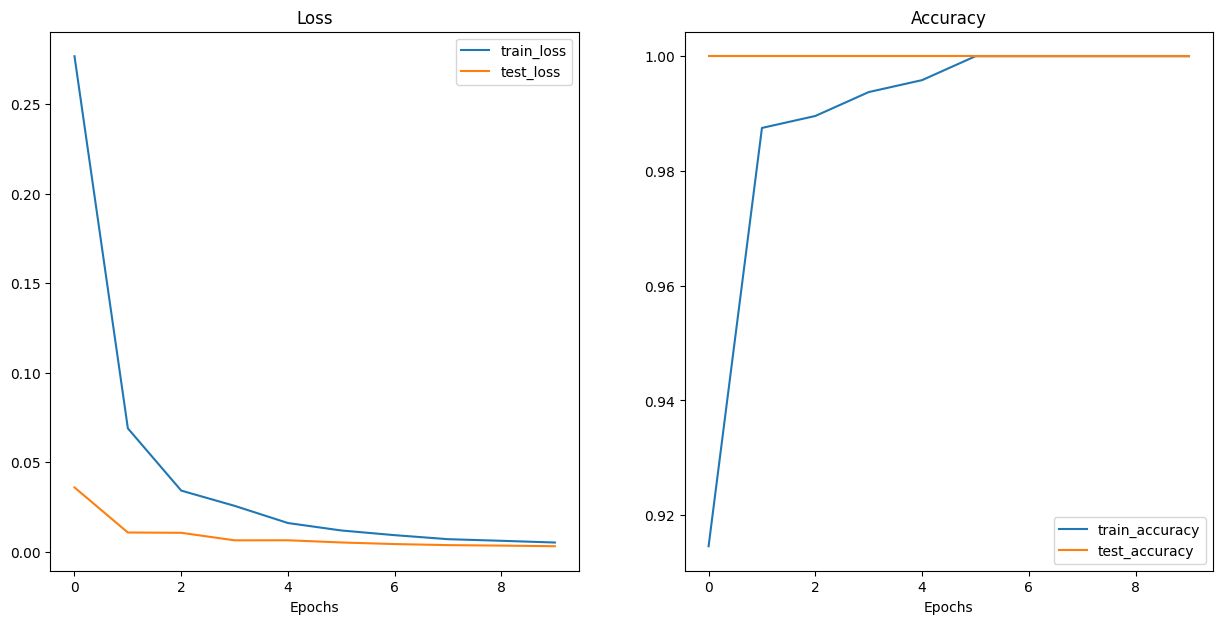

In [35]:
plot_loss_curves(vit_b_16_results)